### Consumo de combustible: Análisis Exploratorio

In [19]:
import pandas as pd

consumo_2024 = pd.read_excel(
    './Datos_consumos/CONSUMO-HIDROCARBUROS-2024-12.xlsx',
    sheet_name='CONSUMO',
    header=6,
    parse_dates=['Fecha']
)

consumo_2025 = pd.read_excel(
    './Datos_consumos/VENTAS-HIDROCARBUROS-2025-05.xlsx',
    sheet_name='VENTAS_IMP',
    header=6,
    parse_dates=['Fecha']
)

consumo = pd.concat([consumo_2024, consumo_2025], ignore_index=True)
consumo.sort_values('Fecha', inplace=True)

consumo.set_index('Fecha', inplace=True)

diesel_cols = [c for c in consumo.columns if 'Diesel' in c]
consumo['Diesel'] = consumo[diesel_cols].sum(axis=1)

df_consumo = consumo.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Super',
    'Gas licuado de petróleo': 'Gas Licuado'
})[['Gasolina Regular', 'Gasolina Super', 'Diesel', 'Gas Licuado']]

df_consumo.head()


,Gasolina Regular,Gasolina Super,Diesel,Gas Licuado
Fecha,,,,
2000-01-01 00:00:00,202645.20,308156.82,634667.06,194410.476190
2000-02-01 00:00:00,205530.96,307766.31,642380.66,174710.552381
2000-03-01 00:00:00,229499.56,331910.29,699807.25,189234.066667
2000-04-01 00:00:00,210680.40,315648.08,586803.98,174330.607143
2000-05-01 00:00:00,208164.34,319667.97,656948.20,191745.147619


In [20]:
import pandas as pd

df_consumo.index = pd.to_datetime(df_consumo.index, errors='coerce')

df_consumo = df_consumo[df_consumo.index.notna()]

df_consumo = df_consumo[~df_consumo.index.duplicated(keep='first')]

df_consumo = df_consumo[df_consumo.index <= '2025-05-01']

print(df_consumo.shape)  
print("Desde", df_consumo.index.min(), "hasta", df_consumo.index.max())


(305, 4)
Desde 2000-01-01 00:00:00 hasta 2025-05-01 00:00:00


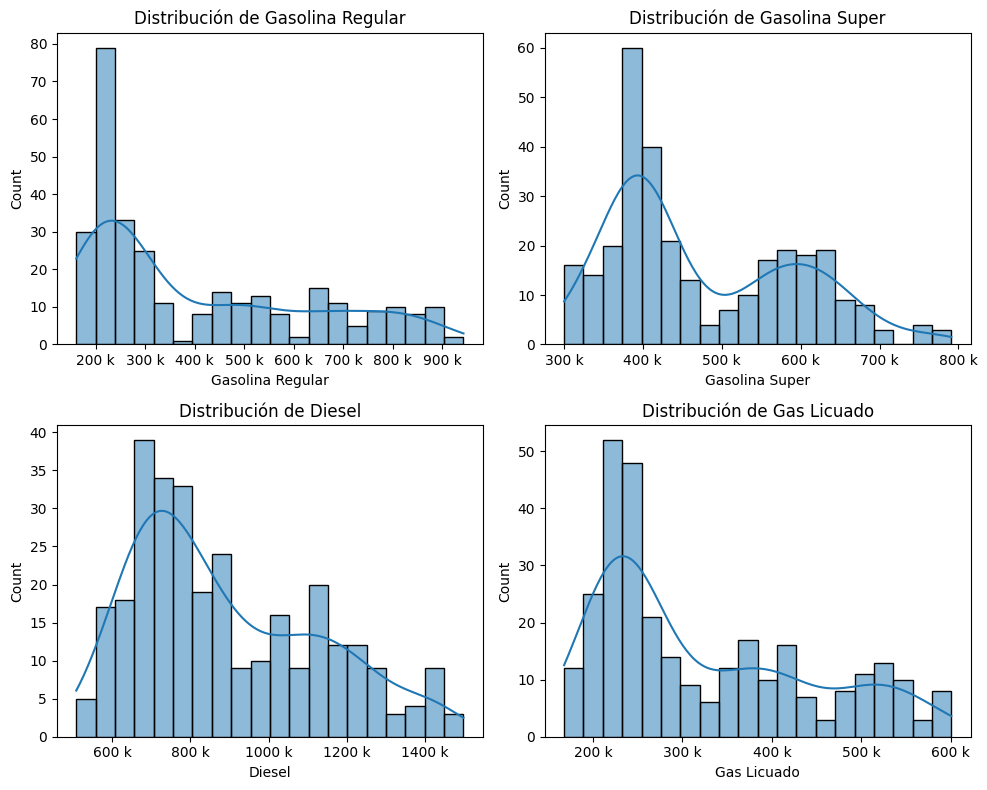

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

k_formatter = mtick.FuncFormatter(lambda x, pos: f'{int(x/1000)} k')

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, col in zip(axes.flatten(), df_consumo.columns):
    sns.histplot(df_consumo[col], bins=20, kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.xaxis.set_major_formatter(k_formatter)
plt.tight_layout()
plt.show()


## Análisis de Serie

Inicio: 2000-01-01
Fin:    2025-05-01
Frecuencia: <MonthBegin>



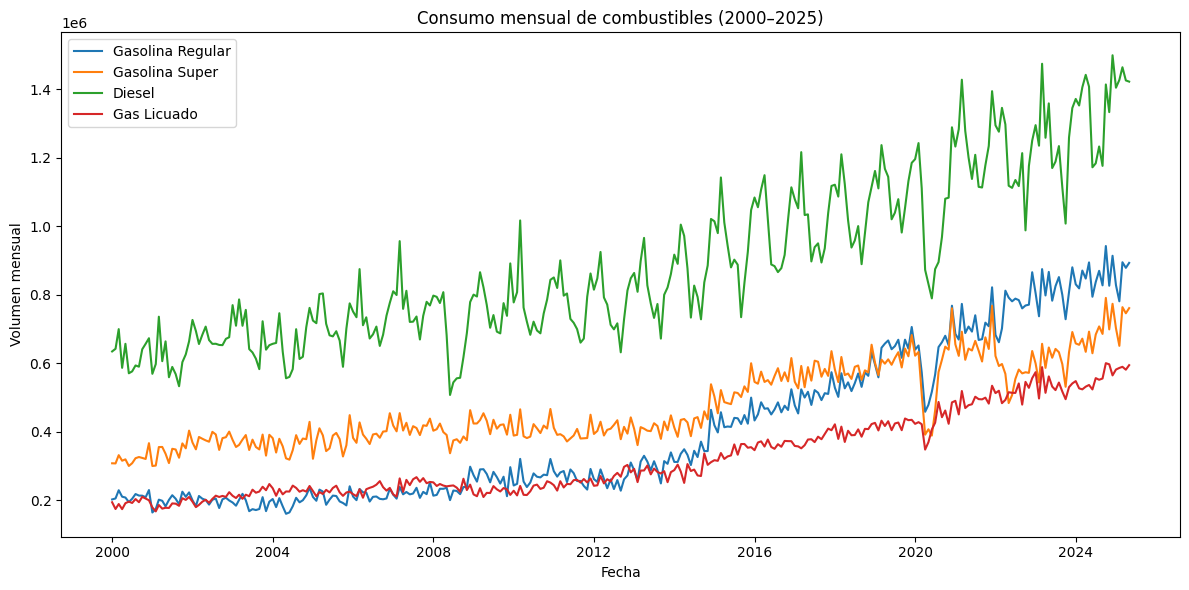

In [22]:
import matplotlib.pyplot as plt

inicio = df_consumo.index.min()
fin    = df_consumo.index.max()

frecuencia = 'MS'

df_consumo.index = pd.DatetimeIndex(df_consumo.index.values, freq=frecuencia)

print(f"Inicio: {inicio.date()}")
print(f"Fin:    {fin.date()}")
print(f"Frecuencia: {df_consumo.index.freq}\n")

plt.figure(figsize=(12, 6))
for col in df_consumo.columns:
    plt.plot(df_consumo.index, df_consumo[col], label=col)
plt.title('Consumo mensual de combustibles (2000–2025)')
plt.xlabel('Fecha')
plt.ylabel('Volumen mensual')
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
df_consumo.isna().sum()

Gasolina Regular    0
Gasolina Super      0
Diesel              0
Gas Licuado         0
dtype: int64

In [24]:
df_consumo.isnull().sum()

Gasolina Regular    0
Gasolina Super      0
Diesel              0
Gas Licuado         0
dtype: int64

In [25]:
df_consumo.isnull().sum().sum()

0

In [ ]:
import os

# Crear carpeta outputs si no existe
os.makedirs('outputs', exist_ok=True)

# Preparar datos para Tableau
# 1. Resetear índice para que Fecha sea una columna con nombre
df_export = df_consumo.reset_index()

# 2. Renombrar la columna de índice
df_export = df_export.rename(columns={'index': 'Fecha'})

# 3. Redondear valores a 2 decimales para mejor legibilidad
columnas_numericas = ['Gasolina Regular', 'Gasolina Super', 'Diesel', 'Gas Licuado']
df_export[columnas_numericas] = df_export[columnas_numericas].round(2)

# 4. Formato de fecha limpio (solo año-mes-día, sin hora)
df_export['Fecha'] = df_export['Fecha'].dt.strftime('%Y-%m-%d')

# Guardar formato ANCHO (wide format) - una fila por fecha, columnas para cada combustible
output_path_wide = os.path.join('outputs', 'consumo_combustibles_wide.csv')
df_export.to_csv(output_path_wide, index=False)

# Guardar formato LARGO (long format) - mejor para Tableau
# Cada fila representa: Fecha | Tipo_Combustible | Volumen
df_long = df_export.melt(
    id_vars=['Fecha'],
    value_vars=columnas_numericas,
    var_name='Tipo_Combustible',
    value_name='Volumen'
)
output_path_long = os.path.join('outputs', 'consumo_combustibles_long.csv')
df_long.to_csv(output_path_long, index=False)

print("Datos guardados exitosamente para Tableau:")
print(f"\n1. Formato ANCHO (Wide): {output_path_wide}")
print(f"   - Dimensiones: {df_export.shape}")
print(f"   - Una fila por fecha, columnas para cada combustible")
print(f"\n2. Formato LARGO (Long): {output_path_long}")
print(f"   - Dimensiones: {df_long.shape}")
print(f"   - mejor para gráficos interactivos en Tableau")
print(f"\n\nPeriodo: {df_export['Fecha'].min()} a {df_export['Fecha'].max()}")

# Mostrar preview de ambos formatos
print("\nPreview formato ANCHO:")
print(df_export.head(3))
print("\nPreview formato LARGO:")
print(df_long.head(8))

Datos guardados exitosamente para Tableau:

1. Formato ANCHO (Wide): outputs\consumo_combustibles_wide.csv
   - Dimensiones: (305, 5)
   - Una fila por fecha, columnas para cada combustible

2. Formato LARGO (Long): outputs\consumo_combustibles_long.csv
   - Dimensiones: (1220, 3)
   - mejor para gráficos interactivos en Tableau


Periodo: 2000-01-01 a 2025-05-01

Preview formato ANCHO:
        Fecha  Gasolina Regular  Gasolina Super     Diesel  Gas Licuado
0  2000-01-01         202645.20       308156.82  634667.06    194410.48
1  2000-02-01         205530.96       307766.31  642380.66    174710.55
2  2000-03-01         229499.56       331910.29  699807.25    189234.07

Preview formato LARGO:
        Fecha  Tipo_Combustible    Volumen
0  2000-01-01  Gasolina Regular  202645.20
1  2000-02-01  Gasolina Regular  205530.96
2  2000-03-01  Gasolina Regular  229499.56
3  2000-04-01  Gasolina Regular  210680.40
4  2000-05-01  Gasolina Regular  208164.34
5  2000-06-01  Gasolina Regular  195088.